<a href="https://colab.research.google.com/github/drewwint/Quant-Family-Collective-fMRI-stats/blob/main/DWinters_QFC_wb4_fMRI_rest_first_level_connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resting-state fMRI: Estimating individual-level functional connectivity
#### Drew E. Winters

In this tutorial, we will take timeseries to estimate functional connectivity (1) across the whole brain, (2) for a specified set of regions making up the default mode network, and (3) seed to voxel connectiviy of the posterior cingulate cortex with the rest of the brain.

For whole brain connectivity, we will first parcelate our brain data using the Multi-subject dictionary learning (MSDL) atlas. For the other methods we will create spheres around specified coordinates and estimate functional connectivity using those spheres.

Althought we will not cover preprocesing in this tutorial - the image below depicts the steps taken up to this point where we will focused on the timecourse extraction and estimating individual-level functional connectivity.


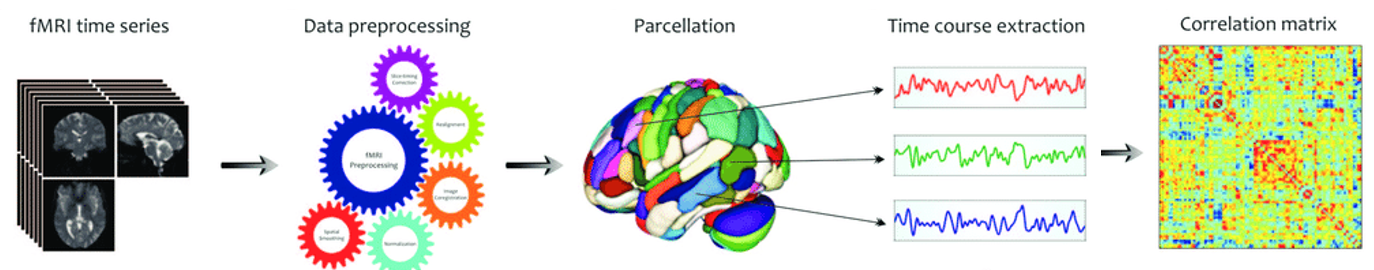
In this tutorial we only focus on estimating connectivity for one subject at the individual level and these are the steps depicted in this image.
- image adaped from Moody et al. (2021).

## Functional connectivity description

What we are doing when we estimate functional connectivity is the degree similarity in BOLD signal between two or more regions. You can get a sense for how similar the BOLD signal between two regions by visually inspecting the timeseries for those regions - if they move in a similar way over time they are likely related and if they move in the opposite way they are anticorrelated. The most common way to quantify this is using a pearson correlation.

Connectivity is based on the hebbian principle that "what fires together wires together" so when regions of the brain are active in a similar way it is reflected in a higher correlation and indicates the degree to which these regions are connected.

With that in mind -- lets consider different approaches to connectivity. We will start with estimating connectivity over the entire brain.


## Whole brain connectivity
### Retrieve the atlas and the data

we will use the Multi-subject dictionary learning (msdl) atlas to parcelate our functional resting data into regions specificed by this atlas.

For this tutorial we will only use one subject to get a sese of how to calculate individual-level connectivity matricies.



In [ ]:
import numpy as np
! pip install nilearn &> /dev/null
! pip install nltools &> /dev/null
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_connectome
import matplotlib.pyplot as plt

atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Loading atlas data stored in 'labels'
labels = atlas["labels"]

# Loading the functional datasets
data = datasets.fetch_development_fmri(n_subjects=1)


Now we will apply the atlas to our data and *extract* the timeseries

In [ ]:
from nilearn.maskers import NiftiMapsMasker

# creating the atlas mask
masker = NiftiMapsMasker(
    maps_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

# applying the mask to the data to extract the timeseries for that atlas
## we are also regressing out confounds to clean the timeseries
time_series = masker.fit_transform(data.func[0], confounds=data.confounds)

[NiftiMapsMasker.wrapped] loading regions from None
Resampling maps
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7e5d35a16c20>, interpolation='continuous', target_shape=(50, 59, 50), target_affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]]))


/usr/local/lib/python3.10/dist-packages/nilearn/_utils/cache_mixin.py:241: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn(


_____________________________________________________resample_img - 3.4s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7e5d35a165f0>, { 'allow_overlap': True,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_maps': True,
  'low_pass': None,
  'maps_img': '/root/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': 'zscore_sample',
  'standardize_confounds': 'zscore_sample',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=[ '/root/nilearn_data/development_fmri/development_fmri/sub

### Estimating Functional Connectivity

With our parcelated timeseries extracted, we will now estimate functional connectivity across the entire brain

#### We will start with an unthresholded pearson correlation approach

In [ ]:
# creating connectivity method
correlation_measure = ConnectivityMeasure(kind='correlation')
# estimating connectivity
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

##### Plotting Pearson Connectivity Matrix

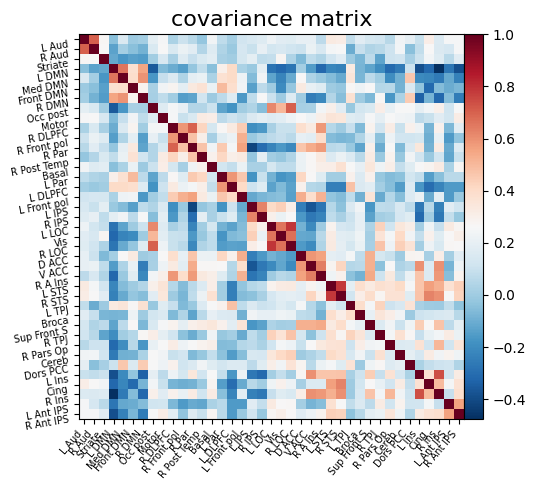

In [ ]:
import nilearn
nilearn.plotting.plot_matrix(correlation_matrix,
                             labels=labels,
                             title = "covariance matrix")

#### Plotting Pearson Connectivity on brain

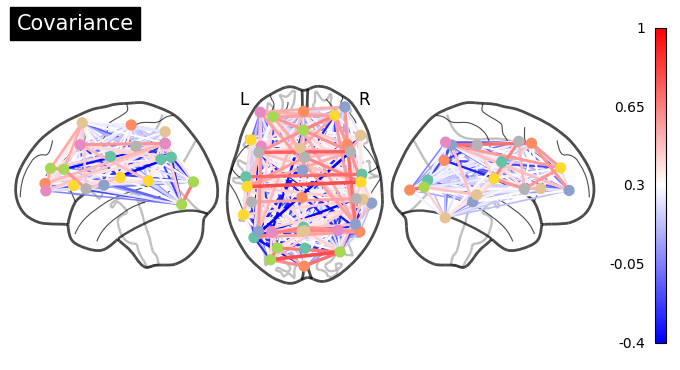

In [ ]:
coords = atlas.region_coords

nilearn.plotting.plot_connectome(correlation_matrix,
                                 coords,
                                 title="Covariance",
                                 edge_vmin=-0.4,
                                 edge_vmax=np.max(correlation_matrix),
                                 colorbar=True,
                                 display_mode='lzr')

#### Thresholding the matrix

While it is debated as to if thresholding is a good idea or not (which likley depends on your research question) here we will apply an 80% threshold on connections inorder to induce sparcity in our matrix.

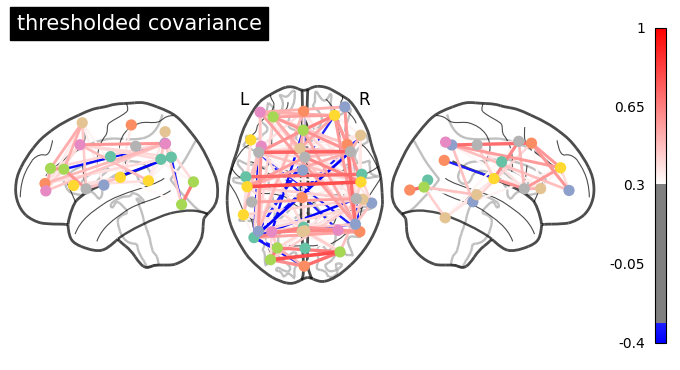

In [ ]:
nilearn.plotting.plot_connectome(correlation_matrix,
                                 coords,
                                 title="thresholded covariance",
                                 edge_threshold='80%',
                                 edge_vmin= -.4,
                                 edge_vmax=np.max(correlation_matrix),
                                 colorbar=True,
                                 display_mode='lzr')

As you can see there are less connections in the plot (or sparse). You may choose to do this in order to remove spurious correlations or noise in your connectivity estimation and/or focus on only the most statistically meaningful connections.

One problem with this approach is that selecting a threshold is arbitrary, which may lead to less generalizable results. Some have raised concerns that thresholding sets the stage for missing important effects (type 2 error) while others raise concerns that **not** thresholding leads to less reliable results due to spurious connections (type 1 error).

To get around the arbitrary nature of thresholding, some have used a principled approach to estimation that introduce sparcity by retaining the most meaninful connections. A few of these approaches include partial correlations, SEM model estimate appraoches, and graphical lasso estimation. Below we will consider graphical lasso and demonsrate that approach

#### Using Graphical Lasso to derive a sparse matrix

Other less arbitrary approaches can also be used for sparcity - here we will use Graphical Lasso for this purpose.

In [ ]:
try:
    from sklearn.covariance import GraphicalLassoCV
except ImportError:
    # for Scitkit-Learn < v0.20.0
    from sklearn.covariance import GraphLassoCV as GraphicalLassoCV

estimator = GraphicalLassoCV()
estimator.fit(time_series)


GraphicalLassoCV()

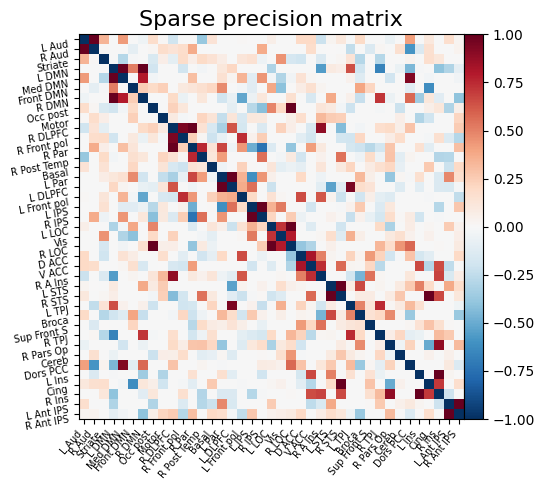

In [ ]:
nilearn.plotting.plot_matrix(
    -estimator.precision_,
    labels=labels,
    vmax=1,
    vmin=-1,
    title="Sparse precision matrix",
)

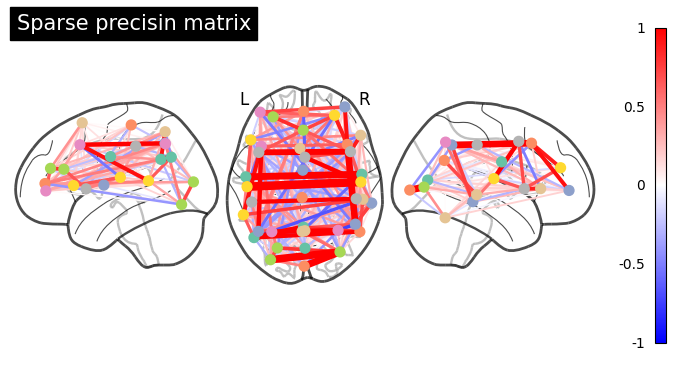

In [ ]:
nilearn.plotting.plot_connectome(
    -estimator.precision_,
    coords,
    title="Sparse precision matrix",
    edge_vmin= -1,
    edge_vmax= 1,
    colorbar=True,
    display_mode='lzr'
)


#### Other plots: 3D View of brain

This is just another demonstration of how we can plot functional connectivity in a 3D brain

In [ ]:
view = nilearn.plotting.view_connectome(correlation_matrix,
                                        coords,
                                        edge_threshold = "90%"
                                        )

view

## Functional Connectivity of the Default Mode Network (DMN)

Lets say you only want to look at connectiviy in the default mode network - lets apply spheres around specific locations of this network to our data so that we only extract coordinates known to be involved in the default mode network.

To do this we will need a list of x, y, z coordinates of the brain for regions we select and then we will create a sphere around this point in the brain inorder to parcel and extract the timeseries for that brain location.

In [ ]:
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
    "Posterior Cingulate Cortex",
    "Left Temporoparietal junction",
    "Right Temporoparietal junction",
    "Medial prefrontal cortex",
]

Extracts signal from sphere around DMN seeds
We can compute the mean signal within spheres of a fixed radius around a sequence of (x, y, z) coordinates with the object nilearn.maskers.NiftiSpheresMasker. The resulting signal is then prepared by the masker object: Detrended, band-pass filtered and standardized to 1 variance.

In [ ]:
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    dmn_coords,
    radius=8,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=2,
    clean__butterworth__padtype="even",  # kwarg to modify Butterworth filter
)

# Additionally, we pass confound information to ensure our extracted
# signal is cleaned from confounds.

func_filename = data.func[0]
confounds_filename = data.confounds[0]

time_series = masker.fit_transform(
    func_filename, confounds=[confounds_filename]
)

________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'allow_overlap': False,
  'clean_kwargs': {'butterworth__padtype': 'even'},
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'high_variance_confounds': False,
  'low_pass': 0.1,
  'mask_img': None,
  'radius': 8,
  'seeds': [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)],
  'smoothing_fwhm': None,
  'standardize': 'zscore_sample',
  'standardize_confounds': 'zscore_sample',
  't_r': 2}, confounds=[ '/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv'], sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=2)
[NiftiSpheresMasker.transform_single_imgs] Loading da

### Examining the extracted DMN node timeseries

Here we will plot the timeseires for every node in the DMN that we extracted.

You may notide that they all seem to move in a similar way (despite some variation) - This is a visual representation of connectivity between these regions.

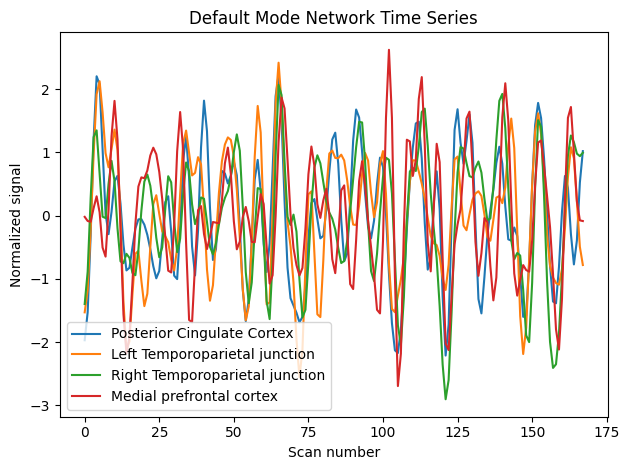

In [ ]:
import matplotlib.pyplot as plt

for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)

plt.title("Default Mode Network Time Series")
plt.xlabel("Scan number")
plt.ylabel("Normalized signal")
plt.legend()
plt.tight_layout()

As you can see these regions appear to visually move in a way that is similar across the timeseries - however we will want to quantify this using a correlation estimate, which we do next.

#### Estimating connectivity for identified DMN spheres

In [ ]:
dmn_matrix = correlation_measure.fit_transform([time_series])[0]

now that we estimated connectivity - lets plot our single-subject data on the brain.

### displaying DMN connectivity

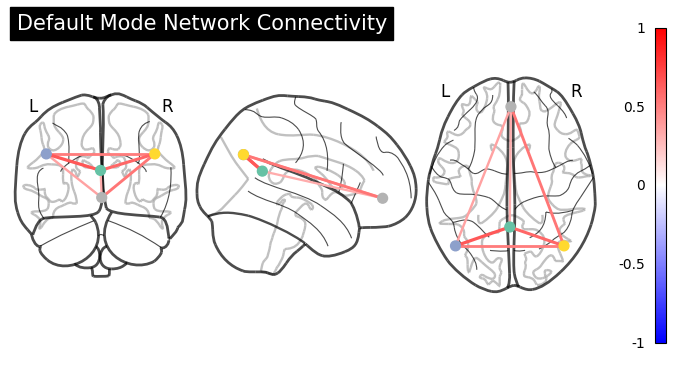

In [ ]:
nilearn.plotting.plot_connectome(
    dmn_matrix,
    dmn_coords,
    title="Default Mode Network Connectivity",
    colorbar=True,
    edge_vmin=-1,
    edge_vmax=1
)

### Parcelating overall DMN connectivity

here we demonstrate extracting a singular value for DMN connectivity by averaging the DMN connectome for this individual.

In [ ]:
np.average(dmn_matrix)

0.6240073994383322

We have an average connectiviy for the DMN of 0.624 - a relatively high level of functional connectivity as expected.

## Seed to voxel functional connectivity

Here - we will create a sphere around our identified seed region (here the posterior cingulate cortex [PCC]) and see estimate its connectivity with every voxel across the entire brain.

To do this we will need to extract the timecourse for our region as well as the timecourses for the rest of the brain (including preprocessing by addressing confounds and filtering our data) and estimate correlation between them.

In [ ]:
# corrdinates for PCC
pcc_coords = [(0, -52, 18)]

Here we create a mask for our PCC coordinate with a radius of 8mm

In [ ]:
from nilearn.maskers import NiftiSpheresMasker

seed_masker = NiftiSpheresMasker(
    pcc_coords,
    radius=8,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)

Now we will extract the tiemseries for our PCC node

In [ ]:
seed_time_series = seed_masker.fit_transform(
    func_filename, confounds=[confounds_filename]
)

Here we model the timeseries across every voxel of the brain

In [ ]:
from nilearn.maskers import NiftiMasker

brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)

And extract tiemseries across every voxel of the brain

In [ ]:
brain_time_series = brain_masker.fit_transform(
    func_filename, confounds=[confounds_filename]
)

### seed to voxel correlation

Here we take the whole brain and seed region to estimate connectiviy of our seed with every voxel of the brain.

In [ ]:
import numpy as np

seed_to_voxel_correlations = (
    np.dot(brain_time_series.T, seed_time_series) / seed_time_series.shape[0]
)

## transforming it to ashieve a normal distribution via z scoring
seed_to_voxel_correlations_fisher_z = np.arctanh(seed_to_voxel_correlations)



### Plotting seed to voxel connectiviy

Here we plot the connectivity of our seed with the rest of the brain for one participant.

We threshold our matrix to only view the correlations above 0.5 in both directions.

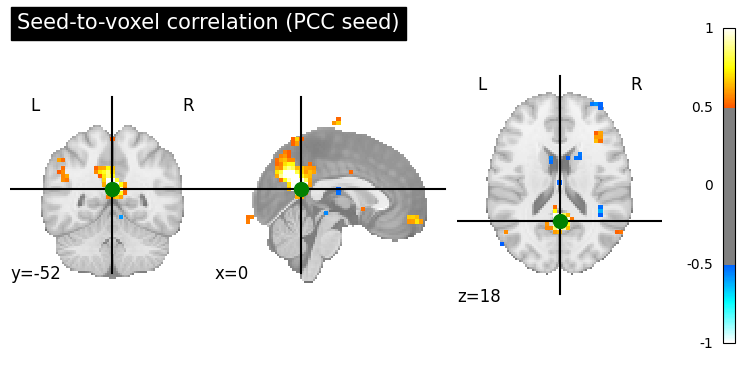

In [ ]:
from nilearn import plotting

seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations_fisher_z.T
)
display = plotting.plot_stat_map(
    seed_to_voxel_correlations_img,
    threshold=0.5,
    vmax=1,
    cut_coords=pcc_coords[0],
    title="Seed-to-voxel correlation (PCC seed)",
)
display.add_markers(
    marker_coords=pcc_coords, marker_color="g", marker_size=100
)
# At last, we save the plot as pdf.
# display.savefig("pcc_seed_correlation.pdf")

### Extracting coordinates of correlated regions

here we obtain the peak correlated regions with the PCC for this individual using the get_clusters command.

These coordinates can be used for reporting and/or look up coordinates on neurosynth.

In [ ]:
from nilearn.reporting import get_clusters_table

In [ ]:
get_clusters_table(seed_to_voxel_correlations_img,
                   stat_threshold = 0.001,
                   cluster_threshold=10,
                   min_distance =20,
                   two_sided=True)

Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1   0.0 -52.0  18.0   1.873763            1140224
1          1a  -4.0 -60.0  42.0   0.932315                   
2          1b -40.0 -76.0  30.0   0.924086                   
3          1c  44.0 -68.0  34.0   0.914746                   
4           2 -48.0 -12.0  70.0   0.228249                704
5           1   8.0  -8.0  22.0  -0.761911             897216
6          1a  12.0 -32.0 -10.0  -0.650362                   
7          1b  24.0 -12.0  78.0  -0.643507                   
8          1c -44.0 -28.0  70.0  -0.642373                   
9           2 -60.0 -64.0 -22.0  -0.434350                896
10          3 -12.0  76.0  10.0  -0.389416               2240
11          4  28.0  16.0 -34.0  -0.192389                640
12          5  56.0 -80.0  18.0  -0.175907                640

### largest cluster centroid

Instead of all the coordinates of peak correlation - you may just want the largest area of correlation - here we do this usign the find_xyz_cut_coords command.

In [ ]:
nilearn.plotting.find_xyz_cut_coords(seed_to_voxel_correlations_img)

[-4.823129368860464, -64.68525333760329, 35.19760471556506]

## Conclusion

Now you should have a sense of how to extimate connectivity on an individual level.

We have demonstrated how you may estiamte (1) whole brain connectivity (2) network level connectivity, and (3) seed to voxel connectivity.

We will now move into making statistical inferences across multiple participants (second-level analyses) to observe any pattern level similarities in relation to a phenotype or gender.